# Time series demo 1: AR(p) models on synthetic data, with known parameters


**Guest lecture**

Columbia IEOR 4729 : _Model Based Trading: Theory and Practice_

Q McCallum (http://qethanm.cc)

In [4]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
np.random.seed( 4729 )

Use some `statsmodels` builtins to generate synthetic data that fits an autoregressive AR(3) model with the parameters: `0.5` , `0.25` , `-0.1`

Of note:

- Since we're using an ARMA generator, we only pass in parameters for the autoregressive model (and leave the params for the moving average model blank)
- Because of how `ArmaProcess` works, we pass in _negative_ values of our AR parameters.  This is only for AR parameters, not MA parameters.

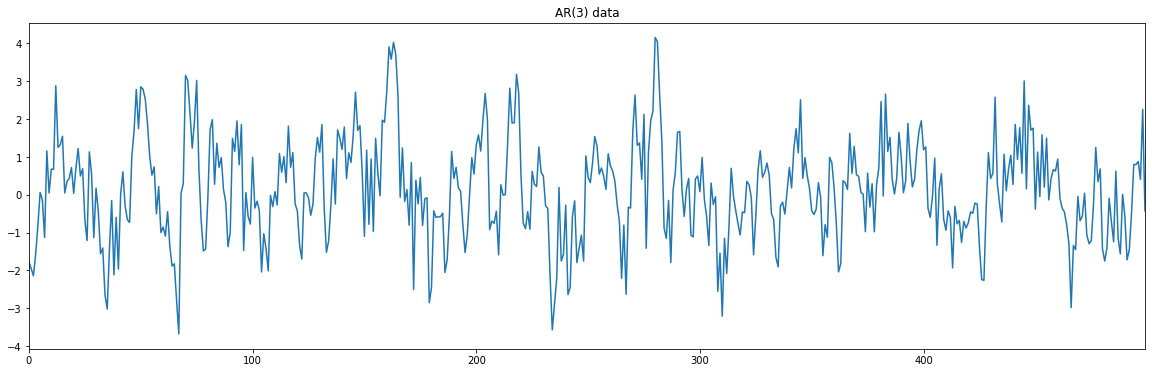

In [6]:
process_ar3 = sm.tsa.ArmaProcess(
    ar = [ 1 , - 0.5 , - 0.25 , 0.1 ] ,
    ma = [ 1 ] ,
)

## Let the ARMA process warm up for a bit (`burnin` parameter)
## and generate 500 points befitting an AR(3) model of our stated parameters
y_ar3 = process_ar3.generate_sample(
    500 ,
    burnin = 1000
)

## being lazy and building a temporary Series for plotting
_ = pd.Series( y_ar3 ).plot(
    title = "AR(3) data" ,
    figsize = ( 20 , 6 )
)

We already know that this is an AR(3) model (with a little noise)
which gives us the chance to test our tools:

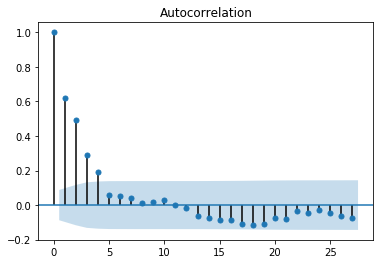

In [8]:
## acf -- autocorrelation function plot, aka "correlogram"
## Correlation of the series, against itself, at different lags.
## The light-blue area represents a confidence interval of 90% or 95%
## (depending on settings) ; any points outside of that range _might_ be significant.

_ = sm.graphics.tsa.plot_acf( y_ar3 )

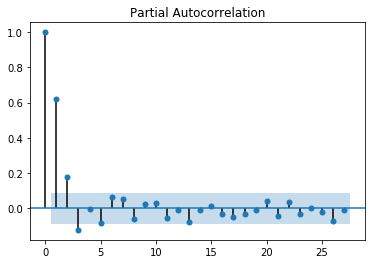

In [9]:
## pacf -- partial autocorrelation function plot
## Similar to autocorrelation function, but removes correlations based on previous lags.
## Once again, points outside of the shaded blue area _might_ be significant.

## For a deeper explanation of ACF vs PACF, see:
## https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8

_ = sm.graphics.tsa.plot_pacf( y_ar3 )

In [ ]:
## That's the data, and that hints at an AR(3) model.  Maybe.  Let's try to fit a model:

In [12]:
## the `(3,0)` is a tuple that reflects the order of the AR and MA portions,
## respectively.  Since this is an AR(3) model that means MA(0), so, we pass `(3,0)`

model_ar3 = sm.tsa.ARMA( y_ar3 , (3,0) )
fit_ar3 = model_ar3.fit( trend="nc" , disp=0 )
fit_ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                     ARMA(3, 0)   Log Likelihood                -718.766
Method:                       css-mle   S.D. of innovations              1.018
Date:                Thu, 16 Apr 2020   AIC                           1445.532
Time:                        17:20:40   BIC                           1462.390
Sample:                             0   HQIC                          1452.147
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5336      0.044     12.007      0.000       0.446       0.621
ar.L2.y        0.2434      0.050      4.908      0.000       0.146       0.341
ar.L3.y       -0.1206      0.045     -2.699      0.007      -0.208      -0.033
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0661           +0.0000j            2.0661            0.5000
AR.2            1.6466           +0.0000j            1.6466            0.0000
AR.3            2.4375           +0.0000j            2.4375            0.0000
-----------------------------------------------------------------------------
"""

In [13]:
## for a fit:
## -  .fittedvalues --> values as generated by this set of params
## -  .resid --> residuals, aka "original data minus fitted values"

## and:
## - y_ar3 --> the original, synthetic data from the series

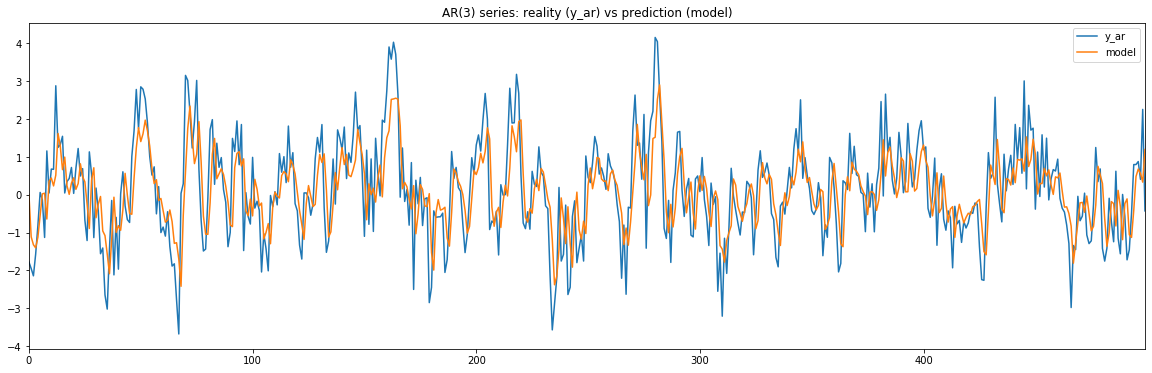

In [14]:
_ = pd.DataFrame(
    {
        "y_ar"   : y_ar3 , 
        "model"  : fit_ar3.fittedvalues
    }
).plot(
    title = "AR(3) series: reality (y_ar) vs prediction (model)" ,
    figsize = ( 20 , 6 )
)

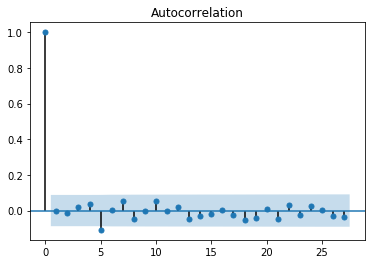

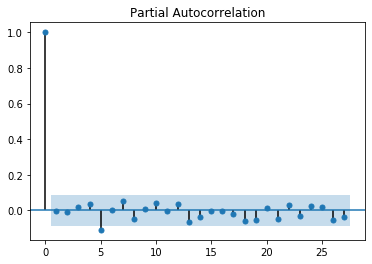

In [15]:
## remember the rule: check your residuals.
_ = sm.graphics.tsa.plot_acf( fit_ar3.resid )
_ = sm.graphics.tsa.plot_pacf( fit_ar3.resid )

This shape on an ACF is a strong hint of white noise: notice, we only get a meaningful correlation at lag 0, which will always be 1.

Since it looks like a lot of random noise /white noise from here ... we're good!

The fit's `summary()` method included some diagnostic values.  Those are useful when _comparing to other fits._  On their own, they don't say a whole lot.

The big ones are:

- **AIC:** Akaike Information Criterion -- judges information loss in a model, based on the likelihood function; penalizes for number of parameters (to avoid overfitting)
- **BIC:** Bayesian Information Criterion -- similar to AIC, but penalizes differently for number of terms


We can test this.  Let's say we _didn't_ know, _a priori,_ that this was an AR(3) model. 

One way to check would be to try a handful of other fits.  We can use a `for` loop for this, and compare the AIC and BIC values that come back.

In [16]:
## We already know this data reflects AR(3) but we'll show a simple way to
## test when we believe a series to be of _some_ kind of AR form:

ar_p_to_try = [
    (5,0) ,
    (4,0) ,
    (3,0) ,
    (2,0) ,
    (1,0) ,
]

param_search_results = []

print( "(Remember: lowest AIC wins)" )

for ar_p in ar_p_to_try :
    print( "trying parameters: {}".format( ar_p ) )
    model_testing = sm.tsa.ARMA( y_ar3 , ar_p ).fit( trend="nc" , disp=0 )
    ## model_testing = sm.tsa.AR( y_ar ).fit( maxlag=10 )

    print( "model params: {}".format( model_testing.params ) )
    print( "AIC:     {}".format( model_testing.aic ) )
    print( "BIC:     {}".format( model_testing.bic ) )
    print()

(Remember: lowest AIC wins)
trying parameters: (5, 0)
model params: [ 0.53293664  0.23459904 -0.09920583  0.03934656 -0.08064541]
AIC:     1446.293099887282
BIC:     1471.5807484778152

trying parameters: (4, 0)
model params: [ 0.53310154  0.24428028 -0.11851828 -0.00386907]
AIC:     1447.5241579963563
BIC:     1468.5971984884673

trying parameters: (3, 0)
model params: [ 0.53356439  0.24336157 -0.12059318]
AIC:     1445.5315610498583
BIC:     1462.3899934435472

trying parameters: (2, 0)
model params: [0.512271   0.18128208]
AIC:     1450.7614539669564
BIC:     1463.405278262223

trying parameters: (1, 0)
model params: [0.62563238]
AIC:     1465.2538197589831
BIC:     1473.6830359558276



We see that the AR(3) model -- parameters `(3,0)` -- has the lowest AIC and BIC, which means that it's the best fit.

That doesn't mean that the lowest fit is the _absolute_ best possible model; it just means that it's the best for the values we tried.  It's entirely possible that a different model altogether would be a better fit.